# 10. Knowledge distillation

DNNは一般的に，ネットワークのパラメータ数を増やす（層の数やチャネル数を増やす）と性能が向上していきます．しかし，ネットワークのパラメータ数を増やすと，それに伴って，実行時に必要なメモリ量や計算コストが増えてしまいます．実応用上，少ないメモリ量と計算コストで高性能な推論ができる小さなネットワークを作ることが望まれます．

Knowledge distillation（知識蒸留）は，そのような小さくて高性能なネットワークを作るための学習方法です．これには，TeacherネットワークとStudentネットワークと呼ばれる2つのネットワークを使用します．以下に，クラス分類問題を解くネットワークにおけるknowledge distillationの学習方法を示します．

<img src="https://paper-attachments.dropbox.com/s_87B2D47FBD0A698415C3853F712E17ACC67F633356B04D1BA9138A68175CE0AD_1596688289510_image.png" width = 40%>

Teacherネットワークは大きくて優秀な事前学習済み(pre-trained)ネットワークであり，StudentネットワークはTeacherネットワークよりも小さなネットワークです．事前学習済みのTeacherネットワークが持っている知識を，Teacherネットワークに教えながら学習させることで，Studentネットワークの性能が向上します．通常の学習では，ネットワークの推論結果が，人間が作成した正解ラベル(Hard target)と一致するように学習を行います．Knowledge distillationでは，Hard targetに加えて，Teacherネットワークの出力(Soft target)にも一致するようにStudentネットワークを学習させます．損失関数はどちらもクロスエントロピー関数を使用します．このように学習することで，distillationを用いない場合よりもStudentネットワークの性能が向上します．

## なぜ性能が向上するのか？

クラス分類問題を解くネットワークを教師あり学習で学習させる場合，教師ラベル(Hard target)として正解クラスのみが1で他のクラスが0になっているデータを使用します．例えば，正解クラスがdogである場合には，以下の図ようにdogクラスのみが1になっており，それ以外のcatやcow, carなどのクラスは0になっている配列 [0, 1, 0, 0, …] を教師ラベルとして使用します．

<img src="https://paper-attachments.dropbox.com/s_87B2D47FBD0A698415C3853F712E17ACC67F633356B04D1BA9138A68175CE0AD_1596368489677_image.png" width = 30%>

これに対して，学習済みのTeacherネットワークが出力する値(Soft target)は，以下の図のように，dogクラス以外にも0より大きな値が存在します．一般的に，この値は正解クラスと見た目が近いほど大きく，遠いほど小さくなります．この例では，dogクラスと見た目が近いcatクラスが2番目に大きな値を持っており，大きく見た目の異なるcarクラスは非常に小さな値となっています．

<img src="https://paper-attachments.dropbox.com/s_87B2D47FBD0A698415C3853F712E17ACC67F633356B04D1BA9138A68175CE0AD_1596368473731_image.png" width = 30%>

つまり，学習済みのネットワークが出力する値には，入力画像に対する正解クラスの類似度情報（ここではdogクラスの0.9）の他に，正解クラス”以外”の類似度情報も含まれています．優秀なTeacherネットワークから得られた，この類似度情報をStudentネットワークに伝えることで，Studentネットワークの精度が向上すると考えられています．（※ただし，理論的な証明はまだ存在していません．また，この他にも”ラベル平滑化”による正則化の効果など，複数の要因によって性能が向上すると考えられています．）

## 学習方法

KDでは以下の2段階の手順でネットワークを学習します．

1. 教師ラベル(hard target)を使ってTeacherネットワークを学習させる
2. 教師ラベル(hard target)と学習済みのTeacherネットワークの出力(soft target)を使ってStudentネットワークを学習させる

#### ステップ 1
Teacherネットワークの学習は通常の教師あり学習です．損失関数として，教師ラベルとのCross entropy lossを使用します．このとき，学習させたTeacherネットワークを保存しておき，次のステップで使います．

#### ステップ 2
Studentネットワークの学習では，教師ラベルを使用した通常の教師あり学習に加え，学習済みTeacherネットワークの出力を模倣するような学習を行います．

教師ラベル(hard target)との損失を計算する際にはcross entropy lossを使用します．損失関数は以下のように表されます．

$$L_{hard} = - \sum^C_i{t_i \log{p^s_i(x)}}$$

ここで，$C$はクラス数，$t_i \in \{0,1\}$は$i$番目クラスの教師ラベル値，$x$は入力画像，$p^s_i$はStudentネットワークの出力をsoftmax関数で正規化した後の，$i$番目クラスの確率値です (例えば，dogクラスの0.9や，catクラスの0.1などです)．この損失関数は，通常の教師あり学習で使用するものとまったく同じ関数です．

Teacherネットワークの出力(soft target)との損失を計算する際にも同様にcross entropy lossを使用します．損失関数は以下のように表されます．これがdistillationに使われる損失関数です．

$$L_{soft} = - \sum^C_i{p^t_i(x; \tau) \log{p^s_i(x; \tau)}}$$

ここで，$p^t_i$はTeacherネットワークの出力をsoftmax関数で正規化した後の，$i$番目クラスの確率値です．また，$\tau$は温度パラメータと呼ばれるもので，softmax関数によって正規化された確率分布の滑らかさを決定する値です．この温度付きsoftmax関数には，Teacherネットワークの情報をStudentネットワークに伝えやすくする役割があります．

最終的な損失は以下のように計算します．$\alpha$は蒸留用の損失をどれだけ考慮するかを決定するパラメータです．
$$L = L_{hard} + \alpha \cdot L_{soft}$$

## Softmax関数の温度パラメータ

温度付きSoftmax関数とは，以下の式で表される関数です．ここで，$z$がネットワークの出力(logits)，$\tau$が温度パラメータを表します．温度$\tau$を高い値にすることで，正規化後の確率分布が滑らかになります．

$$p_i = \frac{exp(z_i/\tau)}{\sum^C_k{exp(z_k/\tau)}}$$

温度付きSoftmax関数の振る舞いを理解するため，以下に温度$\tau$を変更した際の，各クラスの確率値$p_i$の分布を示します．左がネットワークの出力$z_i$の分布，中央が$\tau=1$で$z_i$を正規化したときの確率$p_i$の分布，右が$\tau=4$の場合の確率$p_i$の分布です．温度を上げることで確率分布が変化していることが分かります．(プログラム中の”T”の値を書き換えて，分布がどのように変化するか調べてみてください)

通常のsoftmax関数($\tau=1$の場合に相当)は，最も大きな値のみが1に近く，それ以外は0に近い値となります．この状態のままクロスエントロピー関数を使って蒸留すると，Teacherネットワークが持つ不正解クラスの情報がStudentネットワークにうまく伝わりません．温度パラメータを導入し，$\tau$の値を大きくすることで，不正解クラスの確率値がある程度大きくなるため，その情報が伝わりやすくなります．

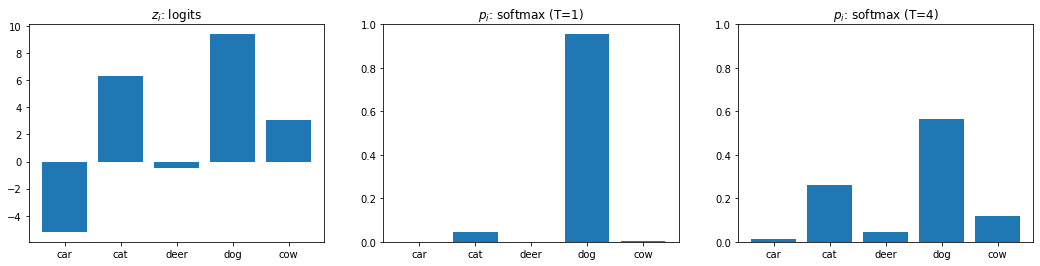

In [1]:
import torch
import matplotlib.pyplot as plt

class_name = ["car","cat", "deer", "dog", "cow"]
z = torch.tensor([-5.2, 6.3, -0.5, 9.4, 3.1])

T = 1
p_1 = torch.softmax(z/T, dim=0)

T = 4
p_4 = torch.softmax(z/T, dim=0)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,4))
ax1.bar(class_name, z)
ax2.bar(class_name, p_1)
ax3.bar(class_name, p_4)
ax2.set_ylim([0,1])
ax3.set_ylim([0,1])
ax1.set_title("$z_i$: logits")
ax2.set_title("$p_i$: softmax (T=1)")
ax3.set_title("$p_i$: softmax (T=4)")
fig.show()

# 畳み込みニューラルネットワークのknowledge distillation
クラス分類問題を解くネットワークに対して，knowledge distillationを適用した学習を行います．
データセットには一般物体認識用のデータセットであるCIFAR-10を使います．CIFAR-10は10クラスの画像からなるデータセットです．
蒸留では，

1. Teacherネットワークを学習させる
2. Studentネットワークを学習させる

という2段階の学習を行います．
この実験の目的は，Studentネットワークの精度が，蒸留を使用しない通常の学習よりも向上するかどうかを確かめることです．
そのため，Studentネットワークを蒸留を用いずに学習させた場合と，蒸留を用いて学習させた場合の2つを比較します．

In [2]:
from time import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchsummary

In [3]:
# エポック数の設定
NUM_EPOCH = 20

In [4]:
# データローダーの準備
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

train_data = torchvision.datasets.CIFAR10(root="./dataset/CIFAR-10", train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root="./dataset/CIFAR-10", train=False, transform=test_transform, download=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=10)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False, num_workers=10)

Files already downloaded and verified
Files already downloaded and verified


## ネットワークの用意
畳み込みネットワークを定義します．ここでは，2層の畳み込み層と3層の全結合層により構成されるネットワークとします．
widen_factorという引数は，畳み込み層のフィルタ数と全結合層のユニット数をデフォルトの値から何倍するかを決定するものです．

In [5]:
class CNN(nn.Module):
    def __init__(self, widen_factor=1):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16*widen_factor, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16*widen_factor, 32*widen_factor, kernel_size=3, stride=1, padding=1)
        self.l1 = nn.Linear(8*8*32*widen_factor, 1024*widen_factor)
        self.l2 = nn.Linear(1024*widen_factor, 1024*widen_factor)
        self.l3 = nn.Linear(1024*widen_factor, 10)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        h = self.pool(self.act(self.conv1(x)))
        h = self.pool(self.act(self.conv2(h)))
        h = h.view(h.size()[0], -1)
        h = self.act(self.l1(h))
        h = self.act(self.l2(h))
        h = self.l3(h)
        return h

## Teacherネットワークの学習

### Teacherネットワークの用意
Teacherネットワークを作成します．今回は，widen_factor=2 の大きなネットワークを用意します．
サマリーの Total params を見ると，パラメータ数が 12,626,890 あることが分かります．

In [6]:
# teacher を用意
teacher = CNN(widen_factor=2).cuda()
# teacher のサマリーを表示
torchsummary.summary(model=teacher, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Linear-7                 [-1, 2048]       8,390,656
              ReLU-8                 [-1, 2048]               0
            Linear-9                 [-1, 2048]       4,196,352
             ReLU-10                 [-1, 2048]               0
           Linear-11                   [-1, 10]          20,490
Total params: 12,626,890
Trainable params: 12,626,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Fo

### 学習 & 評価

In [ ]:
# オプティマイザの設定
optimizer = torch.optim.SGD(teacher.parameters(), lr=0.01, momentum=0.9)

# ネットワークを学習モードへ変更
teacher.train()

start = time()
for epoch in range(1, NUM_EPOCH+1):
    sum_loss = 0.0
    count = 0
    
    for image, label in train_loader:
        
        image = image.cuda()
        label = label.cuda()
        
        y = teacher(image)
        
        # 損失の計算
        loss = F.cross_entropy(y, label)
        
        teacher.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        
        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)
        
    print(f"epoch: {epoch}, mean loss: {sum_loss/len(train_loader)}, mean accuracy: {count.item()/len(train_loader.dataset)}, elapsed_time :{time()-start}")

# ネットワークを評価モードへ変更
teacher.eval()

# 評価の実行
count = 0
with torch.no_grad():
    for image, label in test_loader:
        
        image = image.cuda()
        label = label.cuda()
        
        y = teacher(image)
        
        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

print(f"test accuracy: {count.item()/len(test_loader.dataset)}")

epoch: 1, mean loss: 1.907318680049181, mean accuracy: 0.29028, elapsed_time :92.82638454437256
epoch: 2, mean loss: 1.816010889685154, mean accuracy: 0.34434, elapsed_time :186.4812033176422
epoch: 3, mean loss: 1.8127907244163752, mean accuracy: 0.35192, elapsed_time :279.5665032863617
epoch: 4, mean loss: 1.8259026667112113, mean accuracy: 0.34108, elapsed_time :375.3521873950958
epoch: 5, mean loss: 1.8619633865261078, mean accuracy: 0.3288, elapsed_time :468.97943115234375
epoch: 6, mean loss: 1.870491851181984, mean accuracy: 0.32162, elapsed_time :562.7674753665924
epoch: 7, mean loss: 1.8735470607209206, mean accuracy: 0.32242, elapsed_time :658.047901391983
epoch: 8, mean loss: 1.88550818618536, mean accuracy: 0.31964, elapsed_time :751.8262195587158
epoch: 9, mean loss: 1.895700322008133, mean accuracy: 0.3117, elapsed_time :844.2108945846558
epoch: 10, mean loss: 1.9028598303961755, mean accuracy: 0.30848, elapsed_time :938.1039531230927
epoch: 11, mean loss: 1.8935062318277

### モデルの保存
学習済みのTeacherネットワークの重みパラメータを保存しておきます．こうすることで，再実験を行う際に，Teacherネットワークを再度学習させなくても済むようになります．

In [ ]:
torch.save(teacher, "teacher.pkl")

## Studentネットワーク単体の学習（KDなしの場合）
後で比較をするために，Studentネットワークに対して，knowledge distillationを適用しない通常の学習を行います．

### Studentネットワークの用意
Studentネットワークを作成します．Teacherネットワークよりも小さなネットワークにするため widen_factor=1 にします．Teacherネットワークのパラメータ数は 12,626,890 でしたが，Studentネットワークのパラメータ数は 3,163,114 であり，約4分の1になっていることが分かります．

In [ ]:
# student を用意
student = CNN(widen_factor=1).cuda()
# teacher のサマリーを表示
torchsummary.summary(model=student, input_size=(3,32,32))

### 学習 & 評価

In [ ]:
# オプティマイザの設定
optimizer = torch.optim.SGD(student.parameters(), lr=0.01, momentum=0.9)

# ネットワークを学習モードへ変更
student.train()

start = time()
for epoch in range(1, NUM_EPOCH+1):
    sum_loss = 0.0
    count = 0
    
    for image, label in train_loader:
        
        image = image.cuda()
        label = label.cuda()
        
        y_s = student(image)
        
        # 損失の計算
        loss = F.cross_entropy(y_s, label)
        
        student.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        
        pred = torch.argmax(y_s, dim=1)
        count += torch.sum(pred == label)
        
    print(f"epoch: {epoch}, mean loss: {sum_loss/len(train_loader)}, mean accuracy: {count.item()/len(train_loader.dataset)}, elapsed_time :{time()-start}")

# ネットワークを評価モードへ変更
student.eval()

# 評価の実行
count = 0
with torch.no_grad():
    for image, label in test_loader:
        
        image = image.cuda()
        label = label.cuda()
        
        y = student(image)
        
        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

print(f"test accuracy: {count.item()/len(test_loader.dataset)}")

## Studentネットワークの学習（KDありの場合）
学習済みTeacherネットワークを使ってknowledge distillationを行います．

### Teacherネットワークの読み込み
先ほど保存したTeacherネットワークの重みパラメータをteacherに読み込みます．

In [ ]:
teacher = torch.load("teacher.pkl")

### Studentネットワークの用意
Studentネットワークの重みを初期化するため，再度ネットワークを作成します．

In [ ]:
student = CNN(widen_factor=1).cuda()

### Cross entropy lossの定義
蒸留用の損失関数を定義します．StudentネットワークとTeacherネットワークの出力(logits)に対して温度付きsoftmaxで正規化し，cross entropy lossを計算します．

In [ ]:
def cross_entropy(student_logits, teacher_logits, T):
    student_log_softmax = F.log_softmax(student_logits/T, dim=1)
    teacher_softmax = F.softmax(teacher_logits/T, dim=1)
    ce = -(teacher_softmax * student_log_softmax).sum(dim=1)
    return ce.mean()

### 学習 & 評価
$L_{hard}$と$L_{soft}$の2つの損失関数を使用して，Studentネットワークを学習させます．
今回は，温度パラメータを 4，$\alpha$を 4 に設定します．
Studentネットワークの損失値と精度を表示します．

In [ ]:
# オプティマイザの設定
optimizer = torch.optim.SGD(student.parameters(), lr=0.01, momentum=0.9)

# studentネットワークのみを学習モードへ変更
teacher.eval()
student.train()

start = time()
for epoch in range(1, NUM_EPOCH+1):
    sum_loss = 0.0
    count = 0
    
    for image, label in train_loader:
        
        image = image.cuda()
        label = label.cuda()
        
        # Teacherネットワークの出力を得る
        y_t = teacher(image)
        # Studentネットワークの出力を得る
        y_s = student(image)
        
        # 損失の計算
        hard_loss = F.cross_entropy(y_s, label)
        soft_loss = cross_entropy(y_s, y_t.detach(), T=4.)
        loss = hard_loss + 4.0 * soft_loss
        
        student.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        
        pred = torch.argmax(y_s, dim=1)
        count += torch.sum(pred == label)
        
    print(f"epoch: {epoch}, mean loss: {sum_loss/len(train_loader)}, mean accuracy: {count.item()/len(train_loader.dataset)}, elapsed_time :{time()-start}")

# ネットワークを評価モードへ変更
student.eval()

# 評価の実行
count = 0
with torch.no_grad():
    for image, label in test_loader:
        
        image = image.cuda()
        label = label.cuda()
        
        y = student(image)
        
        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

print(f"test accuracy: {count.item()/len(test_loader.dataset)}")

# 課題
1. 温度パラメータ $\tau$ の値や$\alpha$の値を変更して精度の変化を調査してください．